# Can fingerprint distances discriminate DFG conformations?

The `kissim` fingerprint encodes the pocket residues' spatial distance to four centers&mdash;the pocket centroid, hinge region, DFG region and front pocket&mdash;and should therefore discriminate between two structures in different conformations; when we compare two structures in *different* conformations the fingerprint distance should be higher than for two structures in *similar* conformations.

Let's check if this is true using DFG conformations from KLIFS. Plot distribution of fingerprint distances grouped by in/in, out/out, and in/out pairs.

- Use fingerprint distances for structure pairs between all kinases
- Use fingerprint distances for structure pairs between the same kinase

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from opencadd.databases.klifs import setup_remote
from kissim.comparison import FingerprintDistanceGenerator

from src.definitions import COVERAGE_CUTOFF

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../results/"

In [4]:
plt.style.use("seaborn")

## Load fingerprint distances with sufficient coverage

Choose fingerprint distances that are based on spatial distances only (weighting scheme: 010) and that are based on a sufficient pairwise fingerprint bit coverage (default: `COVERAGE_CUTOFF`).

In [5]:
COVERAGE_CUTOFF

0.8

In [6]:
# Set path
fingerprint_distance_file = DATA / "fingerprint_distances_010.csv"
# Load data
fingerprint_distance_generator = FingerprintDistanceGenerator.from_csv(fingerprint_distance_file)
print(f"Number of kinases: {len(fingerprint_distance_generator.kinase_ids)}")
print(f"Number of structures: {len(fingerprint_distance_generator.structure_ids)}")
structure_distances = fingerprint_distance_generator.data
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances = structure_distances[structure_distances["bit_coverage"] >= COVERAGE_CUTOFF].reset_index(drop=True)
print(f"Number of structure pairs: {structure_distances.shape[0]}")
structure_distances.head()

Number of kinases: 292
Number of structures: 4916
Number of structure pairs: 12081070
Number of structure pairs: 11733382


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage
0,3835,6679,AAK1,AAK1,0.053935,1.0
1,3835,7156,AAK1,AAK1,0.065967,1.0
2,3835,1104,AAK1,ABL1,0.146598,1.0
3,3835,1065,AAK1,ABL1,0.150158,1.0
4,3835,1090,AAK1,ABL1,0.126940,1.0


## Add DFG conformation

Add DFG conformation from KLIFS to each structure pair.

In [7]:
%%time
klifs_session = setup_remote()
structures = klifs_session.structures.all_structures()
dfg = structures.set_index("structure.klifs_id")["structure.dfg"]
structure_distances["dfg.1"] = structure_distances["structure.1"].apply(lambda x: dfg[x])
structure_distances["dfg.2"] = structure_distances["structure.2"].apply(lambda x: dfg[x])
structure_distances.head()

CPU times: user 1min 11s, sys: 477 ms, total: 1min 11s
Wall time: 1min 13s


,structure.1,structure.2,kinase.1,kinase.2,distance,bit_coverage,dfg.1,dfg.2
0,3835,6679,AAK1,AAK1,0.053935,1.0,in,in
1,3835,7156,AAK1,AAK1,0.065967,1.0,in,in
2,3835,1104,AAK1,ABL1,0.146598,1.0,in,out-like
3,3835,1065,AAK1,ABL1,0.150158,1.0,in,out
4,3835,1090,AAK1,ABL1,0.126940,1.0,in,in


## Plot DFG conformation pairs

Group the structure pairs by DFG conformation pairs&mdash;in/in, out/out, in/out&mdash;and plot their fingerprint distance distributions.

In [8]:
def structure_distances_by_dfg_conformation_pairs(structure_distances):
    """Distances for all, in/in, out/out, and in/out structure pairs."""
    
    dfg_all = structure_distances["distance"]
    dfg_in_in = structure_distances[
        (structure_distances["dfg.1"] == "in") 
        & (structure_distances["dfg.2"] == "in")
    ]["distance"]
    dfg_out_out = structure_distances[
        (structure_distances["dfg.1"] == "out") 
        & (structure_distances["dfg.2"] == "out")
    ]["distance"]
    dfg_in_out = structure_distances[
        (
            (structure_distances["dfg.1"] == "in") 
            & (structure_distances["dfg.2"] == "out")
        )
        | (
            (structure_distances["dfg.1"] == "out") 
            & (structure_distances["dfg.2"] == "in")
        )
    ]["distance"]
    
    structure_distances_dfg = pd.DataFrame(
        {
            "all": dfg_all, "in/in": dfg_in_in, "out/out": dfg_out_out, "in/out": dfg_in_out
        }
    )
    structure_distances_dfg = pd.DataFrame(structure_distances_dfg)
    
    return structure_distances_dfg

In [9]:
def plot_structure_distances_by_dfg_conformation_pairs(structure_distances):
    """Plot distribution of structure distances per DFG conformation pair."""
    
    # Data
    structure_distances_dfg = structure_distances_by_dfg_conformation_pairs(structure_distances)
    print("Number of structure pairs per conformation pair:")
    print(structure_distances_dfg.notna().sum())
    
    # Boxplot
    structure_distances_dfg.plot(kind="box", title="Conformation dependent structure pair distances")
    plt.show()
    
    # Stats
    display(structure_distances_dfg.describe())

### All structures

Use fingerprint distances for structure pairs between all kinases.

Number of structure pairs per conformation pair:
all        11733382
in/in       8674987
out/out       99967
in/out      1865839
dtype: int64


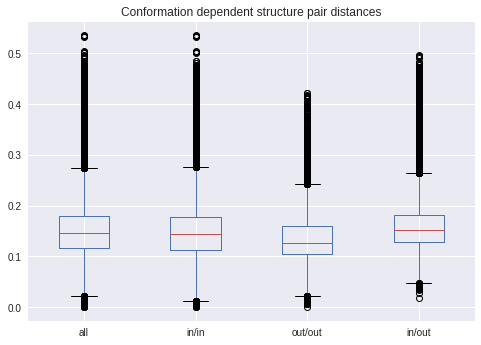

,all,in/in,out/out,in/out
count,1.173338e+07,8.674987e+06,99967.000000,1.865839e+06
mean,1.518736e-01,1.489599e-01,0.137750,1.607469e-01
std,5.115106e-02,5.185786e-02,0.055707,4.802140e-02
min,0.000000e+00,0.000000e+00,0.000000,1.784707e-02
25%,1.166886e-01,1.121125e-01,0.104420,1.280648e-01
50%,1.466822e-01,1.444314e-01,0.125542,1.517770e-01
75%,1.793193e-01,1.780976e-01,0.159610,1.822587e-01
max,5.353785e-01,5.353785e-01,0.422093,4.958527e-01


In [10]:
plot_structure_distances_by_dfg_conformation_pairs(structure_distances)

<div class="alert alert-block alert-info">

When including all kinases at the same time, the distribution of fingerprint distances is similar for structure pairs with the same DFG conformations (in/in and out/out) and different DFG conformations (in/out). 
    
The fingerprint seems not to discriminate DFG-conformations on a kinome-wide level, maybe because the encoded spatial information is not restricted to only DFG conformation features. We may see a disciminative effect when comparing structures for a single kinase.

</div>

### Structures for one kinase

Use fingerprint distances for structure pairs between the same kinase; use only kinases that have a sufficient number of structures in DFG-in and DFG-out conformations (default: 10). 

In [11]:
def kinases_with_high_dfg_in_out_coverage(structure_distances, dfg_structure_coverage_cutoff=10):
    """Given a dataset, get kinases with a threshold DFG in/out coverage."""
    
    # Get structure KLIFS IDs in our dataset
    structure_klifs_ids = pd.concat(
        [
            structure_distances["structure.1"].drop_duplicates(), 
            structure_distances["structure.2"].drop_duplicates()
        ]
    ).drop_duplicates().to_list()
    print(f"Number of structures: {len(structure_klifs_ids)}")
    
    # Get structural metadata
    klifs_session = setup_remote()
    structures = klifs_session.structures.all_structures()
    structures = structures[structures["structure.klifs_id"].isin(structure_klifs_ids)]
    
    # Count number of structures per kinase and conformation
    dfg_by_kinase = structures.groupby("kinase.klifs_name").apply(lambda x: x["structure.dfg"].value_counts())
    dfg_by_kinase = dfg_by_kinase.reset_index()
    dfg_by_kinase.columns = ["kinase", "dfg", "n_structures"]
    
    # Keep only in/out rows
    dfg_by_kinase = dfg_by_kinase[(dfg_by_kinase["dfg"] == "in") | (dfg_by_kinase["dfg"] == "out")]
    
    # Keep only rows with at least xxx structures
    dfg_by_kinase = dfg_by_kinase[dfg_by_kinase["n_structures"] >= dfg_structure_coverage_cutoff]
    
    # Keep only kinases with both in/out conformations
    n_conformations_by_kinase = dfg_by_kinase.groupby("kinase").size()
    dfg_by_kinase = dfg_by_kinase[dfg_by_kinase["kinase"].isin(n_conformations_by_kinase[n_conformations_by_kinase == 2].index)]
    
    return dfg_by_kinase.set_index(["kinase", "dfg"])

In [12]:
dfg_by_kinase = kinases_with_high_dfg_in_out_coverage(structure_distances, dfg_structure_coverage_cutoff=10)
dfg_by_kinase

Number of structures: 4846


n_structures
kinase dfg              
BRAF   in             52
       out            29
EGFR   in            144
       out            10
EphA2  in             36
       out            17
MET    in             49
       out            16
p38a   in            127
       out            74

#### BRAF

Number of DFG-in structures: 52
Number of DFG-out structures: 29
Percentage of DFG-in: 64.2%
Number of structure pairs per conformation pair:
all        3240
in/in      1326
out/out     406
in/out     1508
dtype: int64


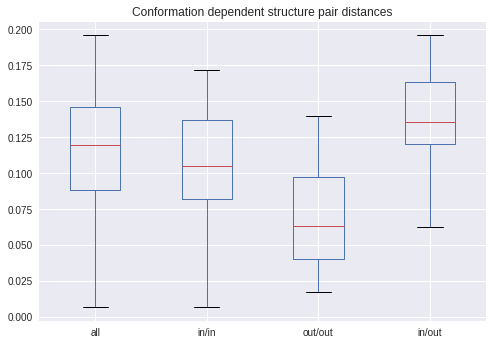

,all,in/in,out/out,in/out
count,3240.000000,1326.000000,406.000000,1508.000000
mean,0.114400,0.102131,0.069350,0.137317
std,0.041485,0.039575,0.031290,0.029225
min,0.006776,0.006776,0.017509,0.062493
25%,0.088342,0.081921,0.040331,0.119979
50%,0.119931,0.105342,0.063570,0.135387
75%,0.145842,0.137047,0.097643,0.163447
max,0.195835,0.171465,0.139937,0.195835


#### EGFR

Number of DFG-in structures: 144
Number of DFG-out structures: 10
Percentage of DFG-in: 93.51%
Number of structure pairs per conformation pair:
all        12720
in/in      10296
out/out       45
in/out      1440
dtype: int64


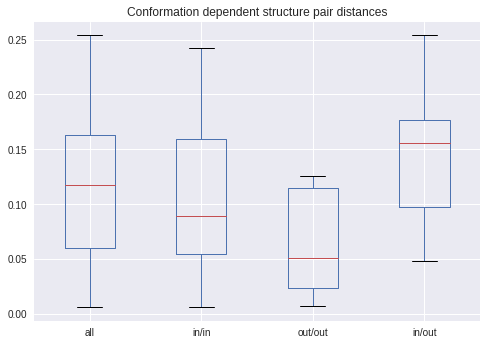

,all,in/in,out/out,in/out
count,12720.000000,10296.000000,45.000000,1440.000000
mean,0.112897,0.105605,0.068989,0.142613
std,0.054063,0.054532,0.045126,0.040115
min,0.006090,0.006090,0.006781,0.048179
25%,0.059780,0.054421,0.023394,0.097384
50%,0.117316,0.089239,0.051204,0.155302
75%,0.162900,0.159669,0.115118,0.176492
max,0.253772,0.242165,0.125830,0.253772


#### EphA2

Number of DFG-in structures: 36
Number of DFG-out structures: 17
Percentage of DFG-in: 67.92%
Number of structure pairs per conformation pair:
all        1378
in/in       630
out/out     136
in/out      612
dtype: int64


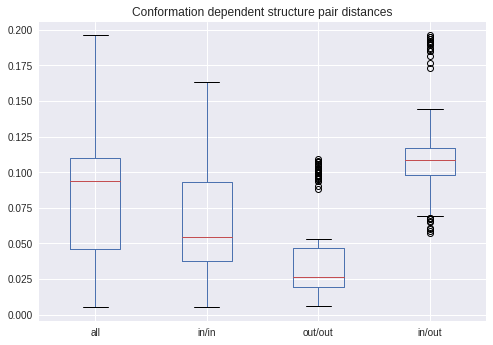

,all,in/in,out/out,in/out
count,1378.000000,630.000000,136.000000,612.000000
mean,0.081709,0.063346,0.042226,0.109387
std,0.039527,0.037389,0.032650,0.019606
min,0.005165,0.005165,0.006354,0.057455
25%,0.046306,0.037473,0.019107,0.097730
50%,0.093450,0.054697,0.026715,0.108559
75%,0.109744,0.093213,0.046466,0.117293
max,0.196033,0.163264,0.109037,0.196033


#### MET

Number of DFG-in structures: 49
Number of DFG-out structures: 16
Percentage of DFG-in: 75.38%
Number of structure pairs per conformation pair:
all        2211
in/in      1176
out/out     120
in/out      784
dtype: int64


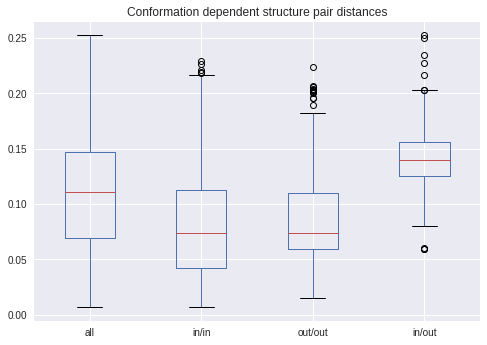

,all,in/in,out/out,in/out
count,2211.000000,1176.000000,120.000000,784.000000
mean,0.107308,0.086336,0.092182,0.140695
std,0.050339,0.052761,0.051939,0.023963
min,0.006791,0.006791,0.015207,0.059057
25%,0.069174,0.042446,0.059070,0.124800
50%,0.110559,0.073395,0.073624,0.140042
75%,0.147206,0.112501,0.110035,0.156143
max,0.252115,0.229456,0.223748,0.252115


#### p38a

Number of DFG-in structures: 127
Number of DFG-out structures: 74
Percentage of DFG-in: 63.18%
Number of structure pairs per conformation pair:
all        28920
in/in       8001
out/out     2701
in/out      9398
dtype: int64


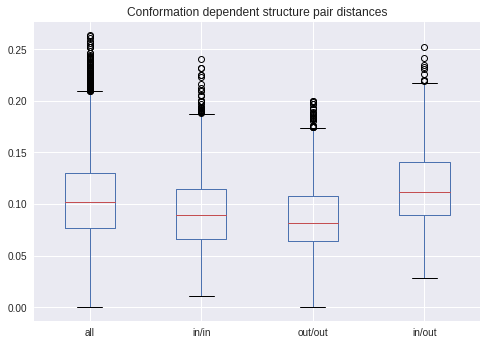

,all,in/in,out/out,in/out
count,28920.000000,8001.000000,2701.000000,9398.000000
mean,0.104478,0.091817,0.086538,0.115213
std,0.036459,0.032808,0.032475,0.032484
min,0.000000,0.011152,0.000000,0.028474
25%,0.076598,0.066430,0.063984,0.089868
50%,0.101966,0.089829,0.081929,0.111808
75%,0.129760,0.114976,0.107962,0.141183
max,0.263483,0.240757,0.200164,0.252040


In [13]:
for kinase, dfg in dfg_by_kinase.reset_index().groupby("kinase"):
    display(Markdown(f"#### {kinase}"))
    dfg = dfg.set_index("dfg")
    n_dfg_in = dfg.loc['in', 'n_structures']
    n_dfg_out = dfg.loc['out', 'n_structures']
    print(f"Number of DFG-in structures: {n_dfg_in}")
    print(f"Number of DFG-out structures: {n_dfg_out}")
    dfg_in_percentage = round(n_dfg_in / (n_dfg_in + n_dfg_out) * 100, 2)
    print(f"Percentage of DFG-in: {dfg_in_percentage}%")
    structure_distances_by_kinase = structure_distances[
        (structure_distances["kinase.1"] == kinase) & (structure_distances["kinase.2"] == kinase)
    ].reset_index(drop=True)
    plot_structure_distances_by_dfg_conformation_pairs(structure_distances_by_kinase)

<div class="alert alert-block alert-info">

We compare here only fingerprint distances for pairs of structures that describe the same kinase. We observe two interesting shifts:
    
1. The distribution for out/out pairs is overall lower than for in/in pairs. Potential explanations: definitions for DFG-out are stricter than for DFG-in; "real" diversity of DFG-out structures could be still unknown due to the lower number of structures for DFG-out than for DFG-in. 
2. The distribution of different DFG conformations (in/out) is overall higher than for equal DFG conformations (in/in and out/out). The fingerprint can discriminate DFG conformations of the same kinase.

</div>